In [ ]:
# Copyright 2021 MIT 6.S191 Introduction to Deep Learning. All Rights Reserved.
# 
# Licensed under the MIT License. You may not use this file except in compliance
# with the License. Use and/or modification of this code outside of 6.S191 must
# reference:
#
# © MIT 6.S191: Introduction to Deep Learning
# http://introtodeeplearning.com
#

# Lab 1: PyTorch 和 RNN 音乐生成简介

# Part 2: 使用 RNN 生成音乐

在实验室的这一部分中，我们将探索构建用于音乐生成的循环神经网络（RNN）。我们将训练一个模型来学习 [ABC 表示法](https://en.wikipedia.org/wiki/ABC_notation) 中原始乐谱的模式，然后使用该模型生成新音乐。

## 2.1 依赖关系 
首先，让我们下载课程存储库，安装依赖项，并导入本实验所需的相关包。

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import lab1
import util
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm


## 2.2 Dataset

![Let's Dance!](http://33.media.tumblr.com/3d223954ad0a77f4e98a7b87136aa395/tumblr_nlct5lFVbF1qhu7oio1_500.gif)

我们收集了数千首爱尔兰民歌的数据集，以 ABC 表示法表示。让我们下载数据集并检查它：

In [2]:
songs = lab1.load_training_data()
example_song = songs[0]
print("\nExample song: ")
print(example_song)

Found 817 songs in text

Example song: 
X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!


我们可以轻松地将 ABC 记谱法的歌曲转换为音频波形并播放。请耐心等待此转换的运行，这可能需要一些时间。

In [3]:
# 将 ABC 乐谱转换为音频文件并收听
lab1.play_song(example_song)

需要考虑的一件重要的事情是，这种音乐符号不仅仅包含正在演奏的音符的信息，还包含元信息，例如歌曲标题、调性和节奏。文本文件中存在的不同字符的数量如何影响学习问题的复杂性？当我们为文本数据生成数字表示时，这一点很快就会变得很重要。

In [4]:
# 将我们的歌曲字符串列表合并到包含所有歌曲的单个字符串中
songs_joined = "\n\n".join(songs) 
# 查找连接字符串中的所有唯一字符
vocab = sorted(set(songs_joined))
print("There are", len(vocab), "unique characters in the dataset")

There are 83 unique characters in the dataset


## 2.3 处理学习任务的数据集
让我们退一步考虑一下我们的预测任务。我们正在尝试训练一个 RNN 模型来学习 ABC 音乐中的模式，然后使用该模型根据学到的信息生成（即预测）一首新的音乐。

分解这个问题，我们真正要问模型的是：给定一个字符或一系列字符，最有可能的下一个字符是什么？我们将训练模型来执行此任务。

为了实现这一目标，我们将向模型输入一个字符序列，并训练模型来预测输出，即每个时间步的后续字符。 RNN 维持依赖于先前看到的元素的内部状态，因此在生成预测时将考虑给定时刻之前看到的所有字符的信息。

### 矢量化文本

在开始训练 RNN 模型之前，我们需要创建基于文本的数据集的数字表示。为此，我们将生成两个查找表：一个将字符映射到数字，第二个将数字映射回字符。回想一下，我们刚刚识别了文本中出现的独特字符。

In [5]:
### 定义文本的数字表示###

# 创建从字符到唯一索引的映射。
# 例如，要获取字符“d”的索引，
# 我们可以评估 `char2idx["d"]`。
char2idx = {u:i for i, u in enumerate(vocab)}

# 创建从索引到字符的映射。这是
# char2idx 的逆并允许我们转换回来
# 从唯一索引到我们词汇表中的字符。
idx2char = np.array(vocab)

这为我们提供了每个字符的整数表示。观察文本中的唯一字符（即我们的词汇表）被映射为从 0 到“len(unique)”的索引。让我们看一下数据集的数字表示：

In [6]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  "'" :   5,
  '(' :   6,
  ')' :   7,
  ',' :   8,
  '-' :   9,
  '.' :  10,
  '/' :  11,
  '0' :  12,
  '1' :  13,
  '2' :  14,
  '3' :  15,
  '4' :  16,
  '5' :  17,
  '6' :  18,
  '7' :  19,
  ...
}


In [7]:
### 向量化歌曲字符串###

'''TODO：编写一个函数将所有歌曲字符串转换为矢量化
    （即数字）表示。使用适当的映射
    上面从词汇字符转换为相应的索引。

  注意：“vectorize_string”函数的输出
  应该是一个包含“N”元素的 np.array，其中“N”是
  输入字符串中的字符数
'''

def vectorize_string(string):
  vectorized_songs = np.array([char2idx[song] for song in string ])
  return vectorized_songs
vectorized_songs = vectorize_string(songs_joined)

我们还可以看看文本的第一部分是如何映射到整数表示的：

In [8]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(songs_joined[:10]), vectorized_songs[:10]))
# 检查 vectorized_songs 是否是一个 numpy 数组
assert isinstance(vectorized_songs, np.ndarray), "returned result should be a numpy array"

'X:1\nT:Alex' ---- characters mapped to int ----> [49 22 13  0 45 22 26 67 60 79]


### 创建培训示例和目标

我们的下一步是将文本实际划分为我们将在训练期间使用的示例序列。我们输入 RNN 的每个输入序列都将包含文本中的“seq_length”字符。我们还需要为每个输入序列定义一个目标序列，该序列将用于训练 RNN 来预测下一个字符。对于每个输入，相应的目标将包含相同长度的文本，只是向右移动了一个字符。

为此，我们将文本分成“seq_length+1”的块。假设 `seq_length` 是 4，我们的文本是“Hello”。那么，我们的输入序列是“Hell”，目标序列是“ello”。

然后，批处理方法将让我们将此字符索引流转换为所需大小的序列。

In [27]:
### 批量定义以创建训练示例###


def get_batch(vectorized_songs, seq_length, batch_size):
  # 矢量化歌曲字符串的长度
  n = vectorized_songs.shape[0] - 1
  # 随机选择训练批次中示例的起始索引
  idx = np.random.choice(n-seq_length, batch_size)

  '''TODO: 构建训练批次的输入序列列表'''
  input_batch = [vectorized_songs[i:i+seq_length] for i in idx]
  '''TODO: 构建训练批次的输出序列列表'''
  output_batch = [vectorized_songs[i+1:i+seq_length+1] for i in idx]

  # x_batch, y_batch 为网络训练提供真实的输入和目标
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch


# 执行一些简单的测试以确保您的批处理功能正常工作！
test_args = (vectorized_songs, 10, 2)
if not lab1.test_batch_func_types(get_batch, test_args) or \
   not lab1.test_batch_func_shapes(get_batch, test_args) or \
   not lab1.test_batch_func_next_step(get_batch, test_args): 
   print("======\n[FAIL] could not pass tests")
else: 
   print("======\n[PASS] passed all tests!")

[PASS] test_batch_func_types
[PASS] test_batch_func_shapes
[PASS] test_batch_func_next_step
[PASS] passed all tests!


对于每个向量，每个索引都在单个时间步处理。因此，对于时间步 0 的输入，模型接收序列中第一个字符的索引，并尝试预测下一个字符的索引。在下一个时间步，它会做同样的事情，但 RNN 除了当前输入之外还考虑上一步的信息，即其更新的状态。

我们可以通过查看文本中前几个字符的工作原理来具体说明这一点：

In [28]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step   0
  input: 59 ('d')
  expected output: 60 ('e')
Step   1
  input: 60 ('e')
  expected output: 59 ('d')
Step   2
  input: 59 ('d')
  expected output: 1 (' ')
Step   3
  input: 1 (' ')
  expected output: 59 ('d')
Step   4
  input: 59 ('d')
  expected output: 60 ('e')


## 2.4 循环神经网络 (RNN) 模型

现在我们准备在 ABC 音乐数据集上定义和训练 RNN 模型，然后使用该训练模型生成一首新歌曲。我们将使用我们在上一节中生成的数据集中的批量歌曲片段来训练 RNN。

该模型基于 LSTM 架构，其中我们使用状态向量来维护有关连续字符之间的时间关系的信息。然后 LSTM 的最终输出被输入到完全连接的  [`nn.Linear`](https://pytorch.org/docs/stable/nn.html#linear-layers) 我们将在该层中输出词汇表中每个字符的 softmax，然后从此分布中进行采样以预测下一个字符。

正如我们在本实验的第一部分中介绍的，我们将使用 nn API，特别是 [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)，定义模型。使用三层来定义模型：

* [`nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html):  这是输入层，由可训练的查找表组成，该查找表将每个字符的数字映射到具有`embedding_dim`维度的向量。
* [`nn.LSTM`](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html): 我们的 LSTM 网络，大小为“units=rnn_units”。
* [`nn.Linear`](https://pytorch.org/docs/stable/nn.html#linear-layers): 输出层，具有“vocab_size”输出。


<img src="https://raw.githubusercontent.com/aamini/introtodeeplearning/2019/lab1/img/lstm_unrolled-01-01.png" alt="Drawing"/>

### 定义 RNN 模型

现在，我们将定义一个用于实际构建模型的函数。

In [29]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)

    def forward(self, x):
        output, _ = self.lstm(x)
        return output

时机已到！在`build_model`函数中填写`TODOs`来定义 RNN 模型，然后调用刚刚定义的函数来实例化模型！

In [30]:
### Defining the RNN Model ###

'''TODO: 添加 LSTM 和 Dense 层以使用 Sequential API 定义 RNN 模型.'''
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = nn.Sequential(
        nn.Embedding(vocab_size, embedding_dim),
        LSTM(embedding_dim, rnn_units),
        nn.Linear(rnn_units, vocab_size)
    )
    return model

# 使用默认超参数构建一个简单模型。您将得到
# 稍后有机会更改这些。
model = build_model(vocab_size=len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)

### 测试 RNN 模型

对我们的模型运行一些简单的检查以查看其行为是否符合预期总是一个好主意。
先，我们可以打印模型的各层信息摘要。在这里我们可以检查模型中的层、每层输出的形状、批量大小等。

In [31]:
print(model)

Sequential(
  (0): Embedding(83, 256)
  (1): LSTM(
    (lstm): LSTM(256, 1024, batch_first=True)
  )
  (2): Linear(in_features=1024, out_features=83, bias=True)
)


我们还可以使用长度为 100 的序列快速检查输出的维数。请注意，该模型可以在任何长度的输入上运行。

In [34]:
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
x = torch.tensor(x)
y = torch.tensor(y)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

Input shape:       torch.Size([32, 100])  # (batch_size, sequence_length)
Prediction shape:  torch.Size([32, 100, 83]) # (batch_size, sequence_length, vocab_size)


### 来自未经训练的模型的预测


让我们看看我们未经训练的模型正在预测什么。

为了从模型中获得实际预测，我们从输出分布中进行采样，该分布由字符词汇表上的“softmax”定义。这将为我们提供实际的字符索引。这意味着我们正在使用[分类分布](https://en.wikipedia.org/wiki/Categorical_distribution) 对示例预测进行采样。这给出了每个时间步的下一个字符（特别是其索引）的预测。

请注意，我们从这个概率分布中进行采样，而不是简单地采用“argmax”，这可能会导致模型陷入循环。

让我们尝试对批次中的第一个示例进行采样。

In [35]:
sampled_indices = torch.multinomial(F.softmax(pred[0], dim=-1), num_samples=1)
sampled_indices = sampled_indices.squeeze().numpy()
print(sampled_indices)

[54 12 33 44 23 63 31 28 23 20 42 16 45 63 60 20 74 45 40 49 74 69  9 19
 73  7 73  1 50 13 27 61 52 78  3  3 35 61 66 78 38 43 76 36 20 49 50 10
 50 55 40 61 53 75 78 23  1 51 78 58 63 47 67 26  2 77 21 39 21 65 38 35
 82 80 77 47 44  6 14 64 81 45 11 80 30 41 62 44  3 67 82 47 58 19 25 30
 75  1 41 49]


我们现在可以解码这些以查看未经训练的模型预测的文本：

In [36]:
print("Input: \n", repr("".join(idx2char[x[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

Input: 
 '8\nK:G Major\nG>A BG|AG BG|G>A BG|AG E2|!\nG>A BG|AG Bd|G>A GE|ED D2:|!\nd>e dB|AG AB|d>e dB|AG E2|!\nd>e'

Next Char Predictions: 
 '^0HS<hFC<8Q4The8sTOXsn-7r)r Y1Bf[w""JfkwMRuK8XY.Y_Of]tw< ZwchVlA!v9N9jMJ|yvVS(2izT/yEPgS"l|Vc7>Et PX'


正如您所看到的，未经训练的模型预测的文本非常荒谬！我们怎样才能做得更好？我们可以训练网络！

## 2.5 Training the model: loss and training operations

Now it's time to train the model!

At this point, we can think of our next character prediction problem as a standard classification problem. Given the previous state of the RNN, as well as the input at a given time step, we want to predict the class of the next character -- that is, to actually predict the next character. 

To train our model on this classification task, we can use a form of the `crossentropy` loss (negative log likelihood loss). Specifically, we will use the [`sparse_categorical_crossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy) loss, as it utilizes integer targets for categorical classification tasks. We will want to compute the loss using the true targets -- the `labels` -- and the predicted targets -- the `logits`.

Let's first compute the loss using our example predictions from the untrained model: 

In [37]:
### Defining the loss function ###

'''TODO: 定义损失函数来计算并返回之间的损失
    真实的标签和预测（logits）。设置参数 from_logits=True。'''
def compute_loss(labels, logits):
    logits = logits.permute(0,2,1)
    labels=labels.to(torch.int64)
    loss = F.cross_entropy(logits, labels)
    return loss
example_batch_loss = compute_loss(y, pred) 

print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.item())

Prediction shape:  torch.Size([32, 100, 83])  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.415406703948975


让我们首先定义一些用于训练模型的超参数。首先，我们为一些参数提供了一些合理的值。您可以使用我们在课堂上学到的知识来帮助优化此处的参数选择！

In [38]:
### Hyperparameter setting and optimization ###

# Optimization parameters:
num_training_iterations = 2000  # Increase this to train longer
batch_size = 4  # Experiment between 1 and 64
seq_length = 100  # Experiment between 50 and 500
learning_rate = 5e-3  # Experiment between 1e-5 and 1e-1

# Model parameters: 
vocab_size = len(vocab)
embedding_dim = 256 
rnn_units = 1024  # Experiment between 1 and 2048

# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

现在，我们准备定义我们的训练操作 - 优化器和训练持续时间 - 并使用此函数来训练模型。您将尝试优化器的选择和训练模型的持续时间，并了解这些更改如何影响网络的输出。您可能想尝试的一些优化器是 [`Adam`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) 和 [`SGD`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)

首先，我们将实例化一个新模型和优化器。然后，我们将使用`LOSS自带的backward()函数`来进行反向传播

我们还将通过训练生成模型进度的打印输出，这将帮助我们轻松可视化是否正在最小化损失。

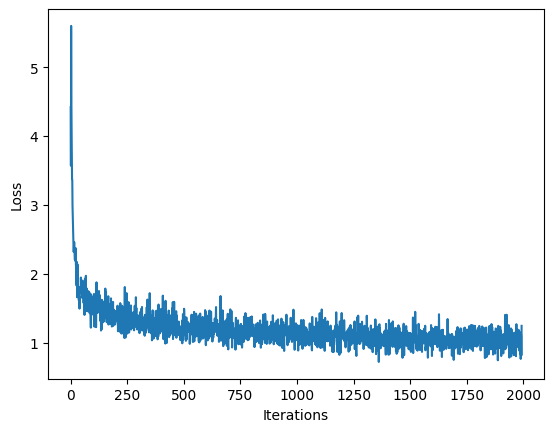

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [06:04<00:00,  5.48it/s]


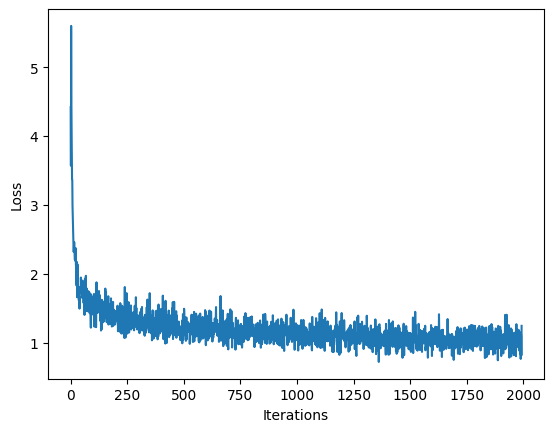

In [40]:
### Define optimizer and training operation ###

'''TODO: instantiate a new model for training using the `build_model`
  function and the hyperparameters created above.'''
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)
model.train()
optimizer = torch.optim.Adam(model.parameters(),learning_rate)
def train_step(x, y):
    optimizer.zero_grad()
    y_hat = model(x)
    loss = compute_loss(y, y_hat)
    loss.backward()
    optimizer.step()
    return loss
history = []
plotter = util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
for iter in tqdm(range(num_training_iterations)):
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  x_batch = torch.tensor(x_batch)
  y_batch = torch.tensor(y_batch)
  loss = train_step(x_batch, y_batch)
  history.append(loss.item())
  plotter.plot(history)
torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    }, checkpoint_dir)
plt.show()


## 2.6 使用 RNN 模型生成音乐

现在，我们可以使用训练好的 RNN 模型来生成一些音乐！生成音乐时，我们必须为模型提供某种种子以使其启动（因为如果没有开始的东西，它就无法预测任何事情！）。

一旦我们生成了种子，我们就可以使用经过训练的 RNN 迭代预测每个连续的字符（请记住，我们使用 ABC 表示音乐）。更具体地说，回想一下我们的 RNN 在可能的连续字符上输出`softmax`。为了进行推理，我们从这些分布中迭代采样，然后使用我们的样本以 ABC 格式对生成的歌曲进行编码。

然后，我们所要做的就是将其写入文件并监听！

### 恢复最新的检查点

为了保持这个推理步骤简单，我们将使用批量大小 1。由于 RNN 状态从一个时间步传递到另一个时间步的方式，模型在构建后只能接受固定的批量大小。

要使用不同的`batch_size`运行模型，我们需要重建模型并从最新的检查点恢复权重，即训练期间最后一个检查点之后的权重：

In [41]:
'''TODO: Rebuild the model using a batch_size=1'''
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
checkpoint = torch.load(checkpoint_dir)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

print(model)

Sequential(
  (0): Embedding(83, 256)
  (1): LSTM(
    (lstm): LSTM(256, 1024, batch_first=True)
  )
  (2): Linear(in_features=1024, out_features=83, bias=True)
)


请注意，我们输入了固定的batch_size` 1 以进行推理。

### 预测程序

现在，我们准备编写代码来生成 ABC 音乐格式的文本：

* 初始化“种子”起始字符串和 RNN 状态，并设置我们想要生成的字符数。

* 使用起始字符串和 RNN 状态来获取下一个预测字符的概率分布。

* 从多项分布中采样来计算预测字符的索引。然后将该预测的字符用作模型的下一个输入。

* 在每个时间步，更新的 RNN 状态都会反馈到模型中，以便模型在进行下一个预测时拥有更多上下文。预测下一个字符后，更新的 RNN 状态再次反馈到模型中，这就是它学习数据中的序列依赖性的方式，因为它从之前的预测中获取了更多信息。

![LSTM 推理](https://raw.githubusercontent.com/aamini/introtodeeplearning/2019/lab1/img/lstm_inference.png)

完成并试验此代码块（以及网络定义和训练的一些方面！），并查看模型的性能。经过少量 epoch 训练后生成的歌曲与经过较长时间训练后生成的歌曲相比如何？

In [42]:
### Prediction of a generated song ###

def generate_text(model, start_string, generation_length=10000):
    # Evaluation step (generating text using the learned RNN model)

    # Convert the start string to numbers (vectorize)
    input_eval = [char2idx[num] for num in start_string]
    input_eval = torch.tensor(input_eval).unsqueeze(0)
    # Empty string to store the generated text
    text_generated = []
    # Here batch size == 1
    # model.apply(weight_reset)
    tqdm._instances.clear()

    for i in tqdm(range(generation_length)):
        predictions = model(input_eval)
        predictions = predictions.squeeze(0)
        predicted_id = torch.multinomial(torch.softmax(predictions, dim=-1), num_samples=1)[-1, 0].item()
        input_eval = torch.tensor([predicted_id]).unsqueeze(0)
        text_generated.append(idx2char[predicted_id])
    return start_string + ''.join(text_generated)
generated_text = generate_text(model, start_string="X", generation_length=30000)

100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [05:57<00:00, 83.93it/s]


 25%|██▍       | 2461/10000 [00:21<01:11, 105.44it/s]

### 播放生成的音乐！

我们现在可以调用一个函数将 ABC 格式文本转换为音频文件，然后播放该文件以检查我们生成的音乐！如果生成的歌曲不够长，请尝试训练更长时间，或者重新生成歌曲！

In [43]:
### Play back generated songs ###

generated_songs = lab1.extract_song_snippet(generated_text)
for i, song in enumerate(generated_songs): 
  # Synthesize the waveform from a song
#   mdl.lab1.play_song(song)
 
   print(song, end="\n\n\n\n")

Found 65 songs in text
X:dBG afeakbg te|ABBE2 gf |-9
K:Dg38 e Csl2D2F FA Wy-rig|gfgasllidBedc|c Mae2GA bagf|GAA GA ag igf|!
d|d/8
[1/f|dfcA|d|DED2A|g|CA|!
g (3|D2|ba/c f|dBddd f A A|dBd:62|F G3 BA A:1/g3A-jigann cB,B|!
X:9
FvecED2BcA A|!
feA|ge2|!
K:|cBcA DEF|f|dcBA b/8



B|kabgf|!
g _e aabag
T:|fe2ABGA/g|BAAc|e-1/AG2BA|fd B|cgf|
aees EDGAG2 agf|E2gf|FFB|abadB|]!
A B|!
dBc|dg|gag|A Monon dBd cA|BdcA|AG|g|!
assridB|ee cBA2A ABG M:|
cA fg|e|!
[1/(32B|dB|c abaag^c|E2AGA M:df|de'ke's A|FA/ aba2|g|BAGBBe>F e Bd Aslig|c|!
AA A e>=fgfe
df Mag d La (3
T: C
gf GBdBB/c|!
K: Issc AGAF eeZ:|cA2G BeAA M: e Bd|gfefe|fecA|(32|!
adf ig: eggfge|fff|FE ite|ddabge de2BB|gf|fd|E2A dg|d|g AcAGBG2 g3:4
A|c ffe2|BdBdeme2 e|F|edBdBc|!
AGE|dfd e f|EA Bc|eB|fee|gfee-reril D|id|Donslid gfdBEF dg|EF|!
dg B|G GF|!
[1/cBd|ec|BGGA|dBG2gba A|A3: M: adB dBe|de2e3 jon a|F BeA (3:|!
de|A CDE|d|Bc|fA|!
DEFA3e dfgedecA d2 cdBABc|dBc cB|gfgelfgf32 BAB|Eg ec|e D|!
X:dB|F M:3
e
agedBc'31/g|!
e/D e|d| Ggabaronm



T:3 CEF DE

## 2.7 尝试并**获得最佳歌曲奖**

恭喜您在 PyTorch 中制作了第一个序列模型！这是一个相当大的成就，希望你能有一些甜美的曲调来展示它。

考虑如何改进模型以及在性能方面最重要的是什么。以下是一些帮助您入门的想法：

* 训练epoch的数量如何影响性能？
* 如果更改或扩充数据集会怎样？
* 起始字符串的选择对结果有显着影响吗？

尝试优化您的模型并提交您最好的歌曲！ 

![跳舞吧！](http://33.media.tumblr.com/3d223954ad0a77f4e98a7b87136aa395/tumblr_nlct5lFVbF1qhu7oio1_500.gif)